<a href="https://colab.research.google.com/github/leomiquelutti/UFU-geofisica-1/blob/master/docs/source/tutorials/survey_study_colab_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Survey Study: a tutorial

This Jupyter notebook aims to help razorback users to compute impedance estimates from the data set shown in the paper in different ways for a two stage remote reference configuration:

1- Ordinary Least Squares

2- M-Estimator 

3- Bounded Influence 

This tutorial is designed for Metronix data format (.ats files).



## Preparing the environment

After you run the cell below, click on `RESTART RUNTIME` before moving in within the notebook. When you restart the runtime, you allow for the changes on the upgraded `matplotlib` package to take effect. 

In [1]:
!pip install razorback
!pip install gitpython
!pip install --upgrade matplotlib

     |████████████████████████████████| 41 kB 509 kB/s 
     |████████████████████████████████| 170 kB 12.5 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 10.3 MB 16.6 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Now that you restarted the runtime, go to the next section to download the data.

## Downloading the data

The cells below both:
* download the data to your environment
* put the calibration files in the proper place

In [1]:
# download the data
import git
git.Git("/content").clone("git://github.com/BRGM/razorback-tutorial-data.git")

GitCommandError: ignored

In [2]:
# put a folder of the calibration files in the right place
!mkdir /usr/local/lib/python3.7/dist-packages/razorback/data/
!cp -r /content/razorback-tutorial-data/metronix_calibration /usr/local/lib/python3.7/dist-packages/razorback/data/

mkdir: cannot create directory ‘/usr/local/lib/python3.7/dist-packages/razorback/data/’: File exists


## Data processing

In [22]:
import razorback as rb # importing the razorback library
import numpy as np # importing the numpy library as np
import matplotlib.pyplot as plt # importing the matplotlib.pyplot library as plt
import urllib.request
import glob
%matplotlib inline

In [23]:
# function for getting sensor information from .ats file header
def sensor(ats_file):
    header = rb.io.ats.read_ats_header(ats_file) #razorback function for ats file data importation
    chan = header['channel_type'].decode()
    stype = ''.join(c for c in header['sensor_type'].decode() if c.isprintable())
    snum = header['sensor_serial_number']
    sampling_rate = header['sampling_rate']
    x1, y1, z1 = header['x1'], header['y1'], header['z1']
    x2, y2, z2 = header['x2'], header['y2'], header['z2']
    L = ((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)**.5
    return chan, L, stype, snum, sampling_rate

In [24]:
# function for getting calibration function from sensor information
def calibration(ats_file, name_converter=None):
    chan, L, stype, snum, sampling_rate = sensor(ats_file)
    if chan in ('Ex', 'Ey'):
        return L
    elif chan in ('Hx', 'Hy', 'Hz'):
        calib_name = f"{stype}{snum:03d}.txt"
        if name_converter:
            calib_name = name_converter.get(calib_name, calib_name)
        return rb.calibrations.metronix(calib_name, sampling_rate)
    raise Exception(f"Unknown channel name: {chan}")

The functions `sensor()` and `calibration()` will help to load the metadata of the data set (electric dipoles length, orientation, calibration files...).

Other strategies for handling these metadata could be used, it's up to you to design your own.


In [25]:
## Create the inventory containing all the time series

# - files is the list of data files to load
# - pattern is applied to each data file to extract the strings {site} and {channel}
# - tag_template create the tag for the data file using {site} and {channel}
files = glob.glob("*/site*/*/*.ats")
pattern = "**/site{site}/*/*_T{channel}_*.ats"
tag_template = "site{site}_{channel}"

# correcting incorrect information about calibration files in file headers
name_converter = {
    'UNKN_H104.txt': 'MFS07104.txt',
    'UNKN_H105.txt': 'MFS07105.txt',
}
files

['razorback-tutorial-data/site100/meas_2016-04-28_19-00-00/415_V01_C03_R000_THy_BL_128H.ats',
 'razorback-tutorial-data/site100/meas_2016-04-28_19-00-00/415_V01_C02_R000_THx_BL_128H.ats',
 'razorback-tutorial-data/site002/meas_2016-04-28_08-20-00/236_V01_C02_R000_THx_BL_128H.ats',
 'razorback-tutorial-data/site002/meas_2016-04-28_08-20-00/236_V01_C03_R000_THy_BL_128H.ats',
 'razorback-tutorial-data/site002/meas_2016-04-28_08-20-00/236_V01_C00_R000_TEx_BL_128H.ats',
 'razorback-tutorial-data/site002/meas_2016-04-28_08-20-00/236_V01_C01_R000_TEy_BL_128H.ats',
 'razorback-tutorial-data/site002/meas_2016-04-28_08-20-00/236_V01_C04_R000_THz_BL_128H.ats',
 'razorback-tutorial-data/site099/meas_2016-04-28_19-00-00/350_V01_C02_R000_THx_BL_128H.ats',
 'razorback-tutorial-data/site099/meas_2016-04-28_19-00-00/350_V01_C03_R000_THy_BL_128H.ats',
 'razorback-tutorial-data/site004/meas_2016-04-28_19-00-00/406_V01_C03_R000_THy_BL_128H.ats',
 'razorback-tutorial-data/site004/meas_2016-04-28_19-00-00/4

In [26]:
# creating and filling the inventory
inv = rb.Inventory()
for fname, [tag] in rb.utils.tags_from_path(files, pattern, tag_template):
    calib = calibration(fname, name_converter)  # getting calibration for data file
    signal = rb.io.ats.load_ats([fname], [calib], lazy=True)  # loading data file
    inv.append(rb.SignalSet({tag:0}, signal))  # tagging and storing the signal

All the data are now loaded in `inventory`.
We can use `inventory` to explore and handle the data set.

You can check the number of files in your inventory `inv`:

In [27]:
len(inv)

24

You can display the tags/labels included in the inventory `inv`

In [28]:
inv.tags

{'site002_Ex',
 'site002_Ey',
 'site002_Hx',
 'site002_Hy',
 'site002_Hz',
 'site004_Ex',
 'site004_Ey',
 'site004_Hx',
 'site004_Hy',
 'site004_Hz',
 'site006_Ex',
 'site006_Ey',
 'site006_Hx',
 'site006_Hy',
 'site006_Hz',
 'site009_Ex',
 'site009_Ey',
 'site009_Hx',
 'site009_Hy',
 'site009_Hz',
 'site099_Hx',
 'site099_Hy',
 'site100_Hx',
 'site100_Hy'}

Creating (using `pack()`) and showing (using `print()`) the SignalSet object for site004 only:

In [29]:
print(inv.filter('site004*').pack())

SignalSet: 5 channels, 1 run
tags: {'site004_Ex': (0,), 'site004_Ey': (1,), 
       'site004_Hx': (2,), 'site004_Hy': (3,), 
       'site004_Hz': (4,)}
----------  -------------------  -------------------
  sampling                start                 stop
       128  2016-04-28 19:00:00  2016-04-29 07:00:00
----------  -------------------  -------------------


Same operation for site099 (magnetic remote reference only):

In [30]:
print(inv.filter('site099*').pack())

SignalSet: 2 channels, 1 run
tags: {'site099_Hx': (0,), 'site099_Hy': (1,)}
----------  -------------------  -------------------
  sampling                start                 stop
       128  2016-04-28 19:00:00  2016-04-29 17:59:00
----------  -------------------  -------------------


Creating and showing the SignalSet object content for the full inventory (including sites 002, 004, 006, 009, 100, 099).
The full data set is reduced to maximal synchronous time section. The `pack()` function is narrowing the time range to the window of common synchronousness of the whole inventory.

In [31]:
print(inv.pack())

SignalSet: 24 channels, 1 run
tags: {'site002_Ex': (0,), 'site002_Ey': (1,), 
       'site002_Hx': (2,), 'site002_Hy': (3,), 
       'site002_Hz': (4,), 'site004_Ex': (5,), 
       'site004_Ey': (6,), 'site004_Hx': (7,), 
       'site004_Hy': (8,), 'site004_Hz': (9,), 
       'site006_Ex': (10,), 'site006_Ey': (11,), 
       'site006_Hx': (12,), 'site006_Hy': (13,), 
       'site006_Hz': (14,), 'site009_Ex': (15,), 
       'site009_Ey': (16,), 'site009_Hx': (17,), 
       'site009_Hy': (18,), 'site009_Hz': (19,), 
       'site099_Hx': (20,), 'site099_Hy': (21,), 
       'site100_Hx': (22,), 'site100_Hy': (23,)}
----------  -------------------  -------------------
  sampling                start                 stop
       128  2016-04-28 19:00:00  2016-04-29 04:00:05
----------  -------------------  -------------------


In [32]:
# Function to prepare signal set from inventory to get it ready for TF estimation procedure
from itertools import chain

def prepare_signalset(inventory, local_site, remote_sites):
    patterns = (f"{e}*" for e in [local_site, *remote_sites])
    signalset = inventory.filter(*patterns).pack()
    tags = signalset.tags
    tags["E"] = tags[f"{local_site}_Ex"] + tags[f"{local_site}_Ey"]
    tags["B"] = tags[f"{local_site}_Hx"] + tags[f"{local_site}_Hy"]
    if remote_sites:
        remote_names = tags.filter(*chain(*(
            (f"{e}_Hx", f"{e}_Hy") for e in remote_sites
        )))
        tags["Bremote"] = sum((tags[n] for n in remote_names), ())
    return signalset

The function `prepare_signalset()` build the SignalSet needed for processing a given `local_site` along with some `remote_sites`.

The function starts by extracting the channels of interest and `pack` them in a SignalSet.
Then that signaset is enriched with specific tags (`'E'`, `'B'` and `'Bremote'`) that will be used later in the TF estimate function.

Showing the SignalSet object with `'E'`, `'B'` and `'Bremote'` tags for processing site004 using sites 100 and 099 as remote references

In [33]:
print(prepare_signalset(inv, 'site004', ['site100', 'site099']))

SignalSet: 9 channels, 1 run
tags: {'site004_Ex': (0,), 'site004_Ey': (1,), 
       'site004_Hx': (2,), 'site004_Hy': (3,), 
       'site004_Hz': (4,), 'site099_Hx': (5,), 
       'site099_Hy': (6,), 'site100_Hx': (7,), 
       'site100_Hy': (8,), 'B': (2, 3), 
       'E': (0, 1), 'Bremote': (6, 5, 7, 8)}
----------  -------------------  -------------------
  sampling                start                 stop
       128  2016-04-28 19:00:00  2016-04-29 07:00:00
----------  -------------------  -------------------


Defining a frequency array in logscale for TF computation

In [34]:
# Definining your output frequency in logscale / you can reduce nb_freq if you want to make a quick test
# as sampling frequency is 128, we go up to half a nyquist frequency which is 32 Hz
# recordings are long enough to try to reach 1 mHz
nb_freq=32
freq = np.logspace(-3, np.log10(32), nb_freq)
print(freq)

[1.00000000e-03 1.39742149e-03 1.95278683e-03 2.72886629e-03
 3.81337640e-03 5.32889414e-03 7.44671121e-03 1.04061943e-02
 1.45418396e-02 2.03210792e-02 2.83971128e-02 3.96827358e-02
 5.54535079e-02 7.74919238e-02 1.08288880e-01 1.51325208e-01
 2.11465098e-01 2.95505873e-01 4.12946259e-01 5.77059977e-01
 8.06396015e-01 1.12687512e+00 1.57471952e+00 2.20054690e+00
 3.07509153e+00 4.29719900e+00 6.00499825e+00 8.39151362e+00
 1.17264815e+01 1.63868373e+01 2.28993186e+01 3.20000000e+01]


### Computing two-stage OLS Impedance estimate for site004 with sites 100 and 99 as remote references 

First stage: a regression is performed to estimate the TF between magnetic field at site 4 and magnetic field at (sites 99 + 100) . Second Stage: the first stage TF is used to produce a synthetic magnetic field and a second regression is operated between the latter and site 4 electric field.  

In [16]:
sig = prepare_signalset(inv, 'site004', ['site100', 'site099'])
print(sig)
ImpOLS = rb.utils.impedance(sig, freq ,remote='Bremote' )
print(ImpOLS.impedance.shape)

SignalSet: 9 channels, 1 run
tags: {'site004_Ex': (0,), 'site004_Ey': (1,), 
       'site004_Hx': (2,), 'site004_Hy': (3,), 
       'site004_Hz': (4,), 'site099_Hx': (5,), 
       'site099_Hy': (6,), 'site100_Hx': (7,), 
       'site100_Hy': (8,), 'B': (2, 3), 
       'E': (0, 1), 'Bremote': (6, 5, 7, 8)}
----------  -------------------  -------------------
  sampling                start                 stop
       128  2016-04-28 19:00:00  2016-04-29 07:00:00
----------  -------------------  -------------------
starting frequency 0.001
starting frequency 0.00139742
starting frequency 0.00195279
starting frequency 0.00272887
starting frequency 0.00381338
starting frequency 0.00532889
starting frequency 0.00744671
starting frequency 0.0104062
starting frequency 0.0145418
starting frequency 0.0203211
starting frequency 0.0283971
starting frequency 0.0396827
starting frequency 0.0554535
starting frequency 0.0774919
starting frequency 0.108289
starting frequency 0.151325
starting frequenc

Showing typical apparent resistivity and phase results using matplotlib

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in arcsin
  """


(-180.0, 180.0)

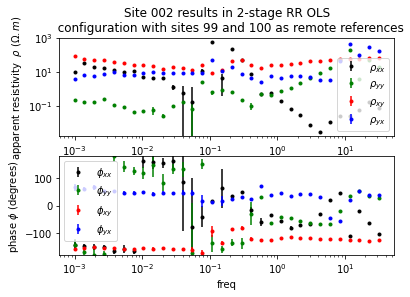

In [17]:
res = ImpOLS
rho = 1e12 * np.abs(res.impedance)**2 / freq[:, None, None]
rho_err = 1e12 * np.abs(res.error)**2 / freq[:, None, None]
phi = np.angle(res.impedance, deg=True)
rad_err = np.arcsin(res.error/abs(res.impedance))
rad_err[np.isnan(rad_err)] = np.pi
phi_err = np.rad2deg(rad_err)

fig = plt.figure()
ax = plt.subplot(2, 1, 1)
ax.set_xscale("log", nonpositive='clip')
ax.set_yscale("log", nonpositive='clip')
ax.errorbar(freq, rho[:,0,0], yerr=rho_err[:,0,0], fmt='k.', label=r'$\rho_{xx}$')
ax.errorbar(freq, rho[:,1,1], yerr=rho_err[:,1,1], fmt='g.', label=r'$\rho_{yy}$')
ax.errorbar(freq, rho[:,0,1], yerr=rho_err[:,0,1], fmt='r.', label=r'$\rho_{xy}$')
ax.errorbar(freq, rho[:,1,0], yerr=rho_err[:,1,0], fmt='b.', label=r'$\rho_{yx}$')
plt.xlabel('freq')
plt.ylabel(r'apparent resistivity  $\rho$ ($\Omega.m$)');
plt.legend()

plt.title('Site 002 results in 2-stage RR OLS\n  configuration with sites 99 and 100 as remote references')
ax = plt.subplot(2, 1, 2)
ax.set_xscale("log", nonpositive='clip')
ax.errorbar(freq, phi[:,0,0], yerr=phi_err[:,0,0], fmt='k.', label=r'$\phi_{xx}$')
ax.errorbar(freq, phi[:,1,1], yerr=phi_err[:,1,1], fmt='g.', label=r'$\phi_{yy}$')
ax.errorbar(freq, phi[:,0,1], yerr=phi_err[:,0,1], fmt='r.', label=r'$\phi_{xy}$')
ax.errorbar(freq, phi[:,1,0], yerr=phi_err[:,1,0], fmt='b.', label=r'$\phi_{yx}$')
plt.xlabel('freq')
plt.ylabel(r'phase $\phi$ (degrees)');
plt.legend()
plt.ylim(-180, 180)


### Now computing 2-stage M-Estimator Transfer Function for site004 with sites 100 and 99 as remote references 

In [18]:
from razorback.weights import mest_weights
from razorback.prefilters import cod_filter

sig = prepare_signalset(inv, 'site004', ['site100', 'site099'])
print(sig)
ImpME = rb.utils.impedance(
    sig, freq,
    weights= mest_weights,
    remote='Bremote', # including the remotes references in the computation,
    prefilter=cod_filter(0.0), # no coherency prefilter...
    fourier_opts=dict( Nper= 8,  overlap= 0.71) # fourier options with 8 periods by window, and 71% of overlap
)
print(ImpME.impedance.shape)

SignalSet: 9 channels, 1 run
tags: {'site004_Ex': (0,), 'site004_Ey': (1,), 
       'site004_Hx': (2,), 'site004_Hy': (3,), 
       'site004_Hz': (4,), 'site099_Hx': (5,), 
       'site099_Hy': (6,), 'site100_Hx': (7,), 
       'site100_Hy': (8,), 'B': (2, 3), 
       'E': (0, 1), 'Bremote': (6, 5, 7, 8)}
----------  -------------------  -------------------
  sampling                start                 stop
       128  2016-04-28 19:00:00  2016-04-29 07:00:00
----------  -------------------  -------------------
starting frequency 0.001
starting frequency 0.00139742
failed to converge (maxit=100). while processing step 2 (weighting=1).
starting frequency 0.00195279
starting frequency 0.00272887
starting frequency 0.00381338
starting frequency 0.00532889
starting frequency 0.00744671
starting frequency 0.0104062
starting frequency 0.0145418
starting frequency 0.0203211
starting frequency 0.0283971
starting frequency 0.0396827
starting frequency 0.0554535
starting frequency 0.0774919
st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in arcsin
  """


(-180.0, 180.0)

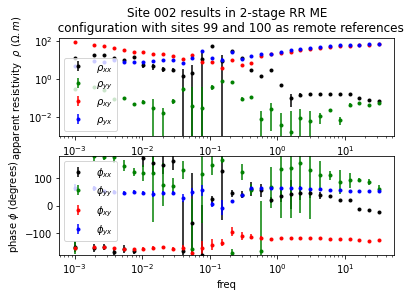

In [19]:
res = ImpME
rho = 1e12 * np.abs(res.impedance)**2 / freq[:, None, None]
rho_err = 1e12 * np.abs(res.error)**2 / freq[:, None, None]
phi = np.angle(res.impedance, deg=True)
rad_err = np.arcsin(res.error/abs(res.impedance))
rad_err[np.isnan(rad_err)] = np.pi
phi_err = np.rad2deg(rad_err)

fig = plt.figure()
ax = plt.subplot(2, 1, 1)
ax.set_xscale("log", nonpositive='clip')
ax.set_yscale("log", nonpositive='clip')
ax.errorbar(freq, rho[:,0,0], yerr=rho_err[:,0,0], fmt='k.', label=r'$\rho_{xx}$')
ax.errorbar(freq, rho[:,1,1], yerr=rho_err[:,1,1], fmt='g.', label=r'$\rho_{yy}$')
ax.errorbar(freq, rho[:,0,1], yerr=rho_err[:,0,1], fmt='r.', label=r'$\rho_{xy}$')
ax.errorbar(freq, rho[:,1,0], yerr=rho_err[:,1,0], fmt='b.', label=r'$\rho_{yx}$')
plt.xlabel('freq')
plt.ylabel(r'apparent resistivity  $\rho$ ($\Omega.m$)');
plt.legend()

plt.title('Site 002 results in 2-stage RR ME\n  configuration with sites 99 and 100 as remote references')
ax = plt.subplot(2, 1, 2)
ax.set_xscale("log", nonpositive='clip')
ax.errorbar(freq, phi[:,0,0], yerr=phi_err[:,0,0], fmt='k.', label=r'$\phi_{xx}$')
ax.errorbar(freq, phi[:,1,1], yerr=phi_err[:,1,1], fmt='g.', label=r'$\phi_{yy}$')
ax.errorbar(freq, phi[:,0,1], yerr=phi_err[:,0,1], fmt='r.', label=r'$\phi_{xy}$')
ax.errorbar(freq, phi[:,1,0], yerr=phi_err[:,1,0], fmt='b.', label=r'$\phi_{yx}$')
plt.xlabel('freq')
plt.ylabel(r'phase $\phi$ (degrees)');
plt.legend()
plt.ylim(-180, 180)


### Now computing 2-stage Bounded Influence Transfer Function for site004 with sites 100 and 99 as remote references for a rejection percentage of 1% and 3 bounded influence steps

In [20]:
from razorback.weights import bi_weights
from razorback.prefilters import cod_filter

sig = prepare_signalset(inv, 'site004', ['site100', 'site099'])
print(sig)
ImpBI = rb.utils.impedance(
    sig, freq,
     weights= bi_weights(0.01, 3),  # bounded influence with reject probability of 1% and 3 steps
    remote='Bremote', # including the remotes references in the computation,
    prefilter=cod_filter(0.0), # prefilter: cod_filter(0.0)
    fourier_opts=dict( Nper= 8,  overlap= 0.71) # fourier options with 8 periods by window, and 71% of overlap
)
print(ImpBI.impedance.shape)

SignalSet: 9 channels, 1 run
tags: {'site004_Ex': (0,), 'site004_Ey': (1,), 
       'site004_Hx': (2,), 'site004_Hy': (3,), 
       'site004_Hz': (4,), 'site099_Hx': (5,), 
       'site099_Hy': (6,), 'site100_Hx': (7,), 
       'site100_Hy': (8,), 'B': (2, 3), 
       'E': (0, 1), 'Bremote': (6, 5, 7, 8)}
----------  -------------------  -------------------
  sampling                start                 stop
       128  2016-04-28 19:00:00  2016-04-29 07:00:00
----------  -------------------  -------------------
starting frequency 0.001
starting frequency 0.00139742
failed to converge (maxit=100). while processing step 2 (weighting=1).
starting frequency 0.00195279
starting frequency 0.00272887
starting frequency 0.00381338
starting frequency 0.00532889
starting frequency 0.00744671
starting frequency 0.0104062
starting frequency 0.0145418
starting frequency 0.0203211
starting frequency 0.0283971
starting frequency 0.0396827
starting frequency 0.0554535
starting frequency 0.0774919
st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in arcsin
  """


(-180.0, 180.0)

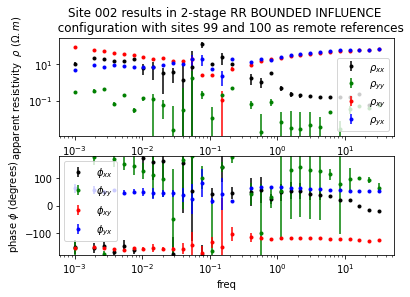

In [21]:
res = ImpBI
rho = 1e12 * np.abs(res.impedance)**2 / freq[:, None, None]
rho_err = 1e12 * np.abs(res.error)**2 / freq[:, None, None]
phi = np.angle(res.impedance, deg=True)
rad_err = np.arcsin(res.error/abs(res.impedance))
rad_err[np.isnan(rad_err)] = np.pi
phi_err = np.rad2deg(rad_err)

fig = plt.figure()
ax = plt.subplot(2, 1, 1)
ax.set_xscale("log", nonpositive='clip')
ax.set_yscale("log", nonpositive='clip')
ax.errorbar(freq, rho[:,0,0], yerr=rho_err[:,0,0], fmt='k.', label=r'$\rho_{xx}$')
ax.errorbar(freq, rho[:,1,1], yerr=rho_err[:,1,1], fmt='g.', label=r'$\rho_{yy}$')
ax.errorbar(freq, rho[:,0,1], yerr=rho_err[:,0,1], fmt='r.', label=r'$\rho_{xy}$')
ax.errorbar(freq, rho[:,1,0], yerr=rho_err[:,1,0], fmt='b.', label=r'$\rho_{yx}$')
plt.xlabel('freq')
plt.ylabel(r'apparent resistivity  $\rho$ ($\Omega.m$)');
plt.legend()

plt.title('Site 002 results in 2-stage RR BOUNDED INFLUENCE \n  configuration with sites 99 and 100 as remote references')
ax = plt.subplot(2, 1, 2)
ax.set_xscale("log", nonpositive='clip')
ax.errorbar(freq, phi[:,0,0], yerr=phi_err[:,0,0], fmt='k.', label=r'$\phi_{xx}$')
ax.errorbar(freq, phi[:,1,1], yerr=phi_err[:,1,1], fmt='g.', label=r'$\phi_{yy}$')
ax.errorbar(freq, phi[:,0,1], yerr=phi_err[:,0,1], fmt='r.', label=r'$\phi_{xy}$')
ax.errorbar(freq, phi[:,1,0], yerr=phi_err[:,1,0], fmt='b.', label=r'$\phi_{yx}$')
plt.xlabel('freq')
plt.ylabel(r'phase $\phi$ (degrees)');
plt.legend()
plt.ylim(-180, 180)